In [1]:
import datetime
import os
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from constants import METRICS_DIR

In [2]:
METRICS_WEIGHTS = {
    "Total Debt": 0,
    "Total Cash": 0,
    "CFO": 0,
    "Revenue": 0,
    "Marcap": 0,

    "EBITDA": 2,
    "Operating Margin": 5,

    # derivatives
    "EV": 0,  # EV = Marcap + Total Debt - Total Cash

    "Total Debt / EBITDA": 7,
    "Total Debt / CFO": 7,
    "Marcap / Sales": 10,  # Marcap / Revenue
    "Marcap / CFO": 9, # Marcap / CFO
    "EV / EBITDA": 8,
}

# ----------
# Directories
WORKDIR = os.path.join(".")
DYNAMIC_METRICS_DIR = os.path.join(METRICS_DIR, "dynamic_metrics")
DATA_SOURCES = ["revenue.csv", "marcap.csv", "operating-margin.csv", "total-debt.csv", "ebitda.csv", "cfo.csv", "total-cash.csv"]

In [3]:
def read_csv_to_df(filename: str) -> pd.DataFrame:
    with open(os.path.join(DYNAMIC_METRICS_DIR, filename)) as f:
        dialect = csv.Sniffer().sniff(f.readline(), delimiters=",;")

    df = pd.read_csv(os.path.join(DYNAMIC_METRICS_DIR, filename), index_col=0, sep=dialect.delimiter, on_bad_lines='warn')
    return df

def prepare_time_series(df: pd.DataFrame):
    df.index = pd.to_datetime(df.index)
    df = df[df.index.year >= 2015]

    # Fill date gaps
    full_date_range = pd.date_range(start=df.index.min(), end=datetime.date.today())
    df = df.reindex(full_date_range)
    df = df.ffill()

    df = df.map(lambda x: str(x).replace(",", ".")).astype(float)
    df.fillna(method="ffill", inplace=True)
    df.fillna(0, inplace=True)
    return df

data = {
    source.rstrip(".csv"): prepare_time_series(read_csv_to_df(source))
    for source in DATA_SOURCES
}

/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Us

In [4]:
data = {
    source.rstrip(".csv"): prepare_time_series(read_csv_to_df(source))
    for source in DATA_SOURCES
}

data["ev"] = data["marcap"] + data["total-debt"] - data["total-cash"]
data["debt_to_ebitda"] = data["total-debt"] / data["ebitda"]
data["debt_to_cfo"] = data["total-debt"] / data["cfo"]
data["marcap_to_sales"] = data["marcap"] / data["revenue"]
data["marcap_to_cfo"] = data["marcap"] / data["cfo"]
data["ev_to_ebitda"] = data["ev"] / data["ebitda"]

/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/tmp/ipykernel_4092/3691959286.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Us

In [5]:
def calculate_avg_std(series: pd.DataFrame, timerange: int = 365):
    """
    Calculate average growth rate and how stable it is.
    :param series:
    :param timerange:
    :return:
    """
    unique_vals = series[-timerange:][np.where(series[-timerange:].diff() != 0)[0]]
    perc_chg = (unique_vals - unique_vals.shift()) / unique_vals
    avg_chg = perc_chg[-6:].mean()
    std_to_mean = perc_chg.std() / avg_chg

    return avg_chg, abs(std_to_mean)

def normalize_ewm_growth(series: pd.Series, timerange: int = 365, low: float = .0, high: float = .05) -> pd.Series:
    """
    Calculate exponential moving average and normalize it by a given value range.
    :param timerange:
    :param series:
    :param low:
    :param high:
    :return:
    """

    unique_vals = series[-timerange:][np.where(series[-timerange:].diff() != 0)[0]]
    perc_chg = (unique_vals - unique_vals.shift()) / unique_vals
    ewm = perc_chg.ewm(alpha=0.5).mean()
    norm_ewm = (ewm - low) / (high - low)
    return norm_ewm

def normalize_growth_rate(series: pd.Series, timerange: int = 365, low: float = .0, high: float = .05) -> pd.Series:
    """
    Calculate exponential moving average and normalize it by a given value range.
    :param timerange:
    :param series:
    :param low:
    :param high:
    :return:
    """

    unique_vals = series[-timerange:][np.where(series[-timerange:].diff() != 0)[0]]
    perc_chg = (unique_vals - unique_vals.shift()) / unique_vals
    norm_ewm = (perc_chg - low) / (high - low)
    return norm_ewm

def normalize_by_quantile_band(
        series: pd.Series,
        timerange: int = 365,
        q_low: float = .2,
        q_high: float = .8
) -> float:
    """
    Normalize last datapoint to quantile band along the given timerange.

    :param series:
    :param timerange:
    :param q_low:
    :param q_high:
    :return:
    """
    qh = series[-timerange:].quantile(q_high)
    ql = series[-timerange:].quantile(q_low)
    return (series[-1] - ql) / (qh - ql)

def calculate_debt_dynamic_score(series: pd.Series, threshold: float, smoothing: bool = True, n_quarters: int = 5) -> float:
    """
    Measure debt dynamic. 0 - good, 1 - bad.
    :param n_quarters:
    :param smoothing:
    :param threshold:
    :param series:
    :return:
    """
    # 1. If above threshold
    above_thresh = series[-1] > threshold

    # 2. Is last 5 quarters debt growth is "under control" (for how many quarters 3Y ewm < threshold)
    if smoothing:
        series_norm = normalize_ewm_growth(series, 3*365, low=-0.02, high=0.05)
    else:
        series_norm = normalize_growth_rate(series, 3*365, low=-0.02, high=0.05)

    qs = np.array([series_norm[-q:].mean() for q in range(n_quarters, 0, -1)])
    duc_quarters = (qs <= 1).mean()  # debt-under-control quarters

    # 3. Non-increasing debt score. 0 - increasing all the time, 1 - non-increasing all the time.
    epsilon = 0.1
    debt_down_points = 0
    for x in range(n_quarters - 1):
        debt_down_points += (qs[x] + epsilon >= qs[x+1:]).sum()
    debt_down_ratio = debt_down_points / 10

    # 1st component tells if debt is high,
    # 2nd and 3rd components tell whether company keeps it under control and reduces it regularly.
    return float(above_thresh) * (1 - (duc_quarters + debt_down_ratio) / 2)

In [6]:
ebitda_chg, ebitda_std = calculate_avg_std(data["ebitda"]["$MRK"], 3*365)
op_margin_chg, op_margin_std = calculate_avg_std(data["operating-margin"]["$MRK"], 3*365)

/tmp/ipykernel_4092/280384251.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unique_vals = series[-timerange:][np.where(series[-timerange:].diff() != 0)[0]]


In [7]:
ebitda_chg, ebitda_std, op_margin_chg, op_margin_std

(np.float64(-0.14157344714001743),
 np.float64(3.2733295802370272),
 np.float64(-0.4594341866418847),
 np.float64(2.1097081748227082))

In [8]:
l, h = -0.05, 0.1

In [9]:
unique_vals = data["ebitda"]["$MRK"][-7*365:][np.where(data["ebitda"]["$MRK"][-7*365:].diff() != 0)[0]]
perc_chg = (unique_vals - unique_vals.shift()) / unique_vals

ewm = unique_vals.ewm(span=9).mean()
chg_ewm = perc_chg.ewm(span=9).mean()

/tmp/ipykernel_4092/2649306439.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unique_vals = data["ebitda"]["$MRK"][-7*365:][np.where(data["ebitda"]["$MRK"][-7*365:].diff() != 0)[0]]


In [10]:
import datetime

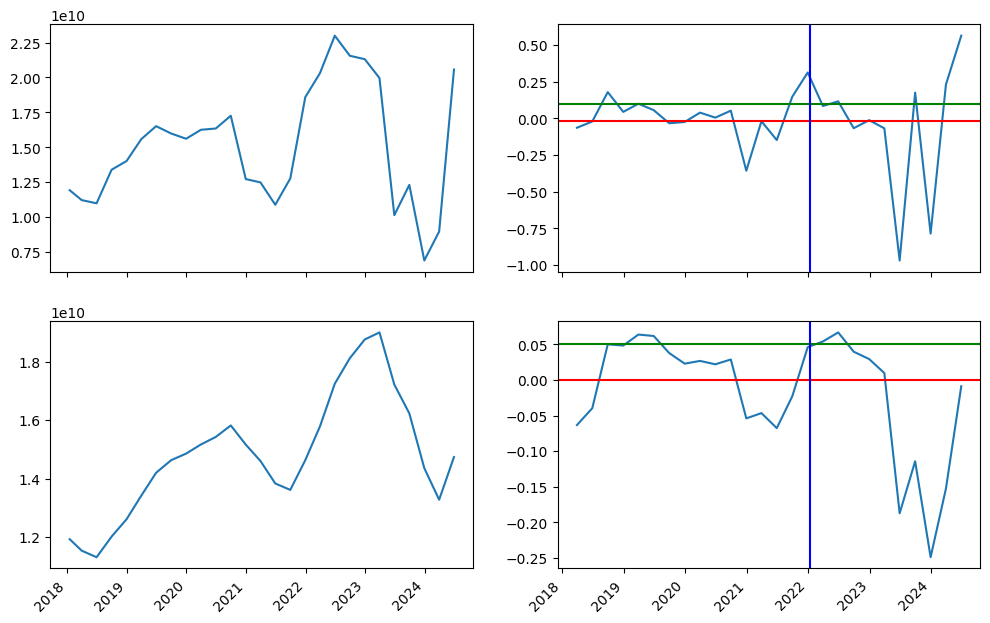

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

axes[0, 0].plot(unique_vals)
axes[0, 1].plot(perc_chg)
axes[0, 1].axhline(y = -0.02, color = 'r', linestyle = '-') 
axes[0, 1].axhline(y = 0.1, color = 'g', linestyle = '-') 
axes[0, 1].axvline(x = datetime.date.today() - datetime.timedelta(days=3*365), color = 'b', linestyle = '-') 
axes[1, 0].plot(ewm)
axes[1, 1].plot(chg_ewm)
axes[1, 1].axhline(y = 0.0, color = 'r', linestyle = '-') 
axes[1, 1].axhline(y = 0.05, color = 'g', linestyle = '-') 
axes[1, 1].axvline(x = datetime.date.today() - datetime.timedelta(days=3*365), color = 'b', linestyle = '-')
fig.autofmt_xdate(rotation=45)
plt.show()

---
Objective

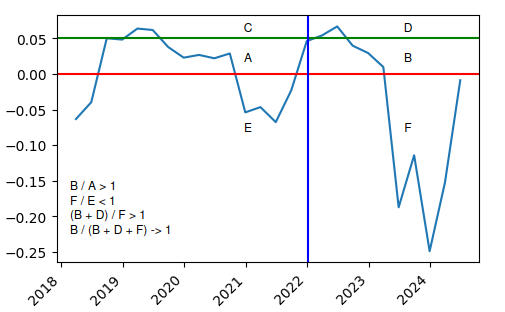

---

In [12]:
unique_vals = data["operating-margin"]["$MRK"][-3*365:][np.where(data["operating-margin"]["$MRK"][-3*365:].diff() != 0)[0]]
perc_chg = (unique_vals - unique_vals.shift()) / unique_vals

/tmp/ipykernel_4092/3762712000.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unique_vals = data["operating-margin"]["$MRK"][-3*365:][np.where(data["operating-margin"]["$MRK"][-3*365:].diff() != 0)[0]]


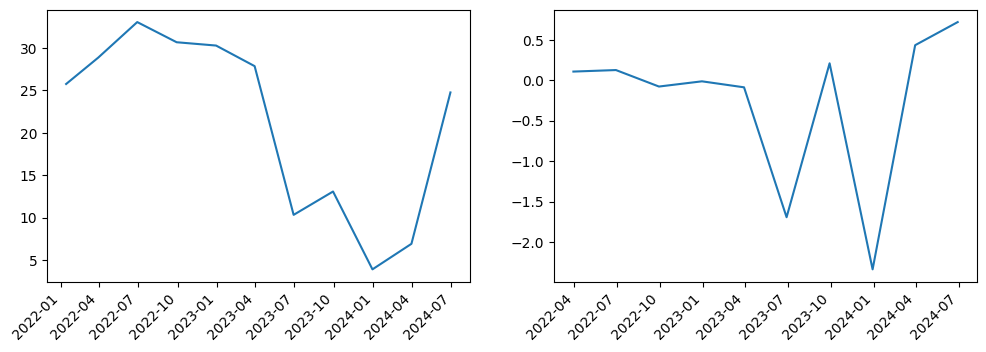

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(unique_vals)
axes[1].plot(perc_chg)
fig.autofmt_xdate(rotation=45)
plt.show()

In [14]:
ebitda_chg, ebitda_std = calculate_avg_std(data["ebitda"]["$MRK"], 3*365)
op_margin_chg, op_margin_std = calculate_avg_std(data["operating-margin"]["$MRK"], 3*365)

/tmp/ipykernel_4092/280384251.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unique_vals = series[-timerange:][np.where(series[-timerange:].diff() != 0)[0]]


In [37]:
def norm_to_pi_by_2(x):
    return(np.sin(np.clip(x, 0, 1) * np.pi / 2))

def f_stable_growth(growth_rate: float, a=0.02, b=0.07, c=-0.05, d=0.25, f=0.2):
    if a <= growth_rate <= b:
        return 1
    elif c <= growth_rate <= a:
        return norm_to_pi_by_2(((growth_rate - c) / (a - c)))
    elif b <= growth_rate <= d:
        return (1 - f) * norm_to_pi_by_2(1 - (growth_rate - b) / (d - b)) + f
    elif growth_rate > d:
        return f
    else:
        return 0 

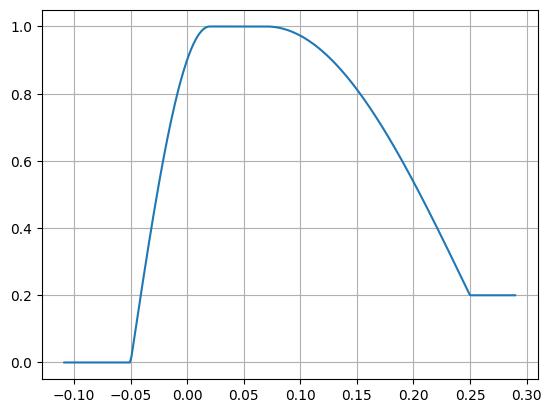

In [47]:
xpoints = sorted(0.4 * np.random.rand(1000,) - 0.11)
ypoints = np.array([f_stable_growth(x) for x in xpoints])

plt.plot(xpoints, ypoints)
plt.grid(True)
plt.show()

In [55]:
st_growth = pd.Series([f_stable_growth(chg) for chg in perc_chg], index=perc_chg.index)

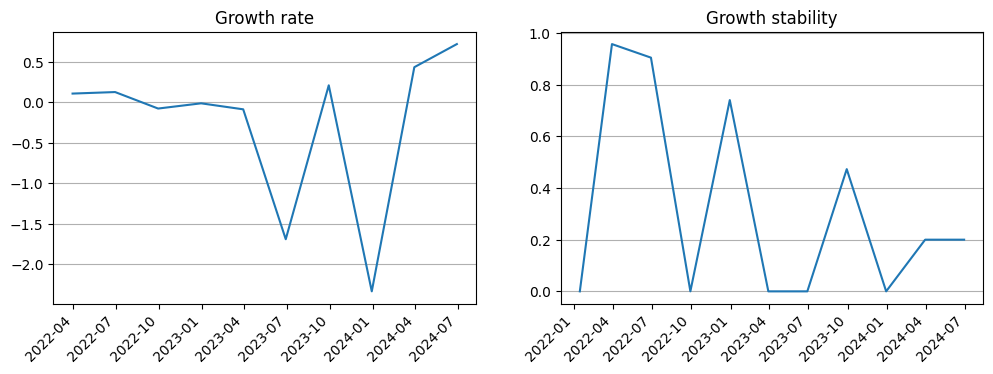

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(perc_chg)
axes[0].set_title("Growth rate")
axes[1].plot(st_growth)
axes[1].set_title("Growth stability")
fig.autofmt_xdate(rotation=45)
axes[0].grid(True, axis='y')
axes[1].grid(True, axis='y')
plt.show()

### Seasonality

In [57]:
st_growth

2022-01-14    0.000000
2022-03-30    0.956952
2022-06-29    0.904474
2022-09-29    0.000000
2022-12-30    0.740265
2023-03-30    0.000000
2023-06-29    0.000000
2023-09-29    0.472984
2023-12-30    0.000000
2024-03-30    0.200000
2024-06-29    0.200000
dtype: float64